# 1.0 Business Problem

Logistics is the largest and fastest-growing fully integrated player in India by revenue in Fiscal 2021.The company wants to understand and process the data coming out of data engineering pipelines:
- Clean, sanitize and manipulate data to get useful features out of raw fields
- Make sense out of the raw data and help data science team to build forecasting models on it


## 1.1 Data Problem  
  help data science team to build forecasting models by  
-  explore data, clean,sanitize and perform EDA
- Analyse attributes and perform hypothesis tests to understand relationship between factors   
- Feature Creation
- Column Normalization /Column Standardization
- Handling categorical values
- Missing values - Outlier treatment / Types of outliers

## 1.2 Column Profile
-**data** - tells whether the data is testing or training data    
-**trip_creation_time** – Timestamp of trip creation    
-**route_schedule_uuid** – Unique Id for a particular route schedule    
-**route_type** – Transportation type       
   - __FTL__ – Full Truck Load: FTL shipments get to the destination sooner, as the truck is making no other pickups or drop-offs along the way    
   - __Carting__: Handling system consisting of small vehicles (carts)      
   
- **trip_uuid** - Unique ID given to a particular trip (A trip may include different source and destination centers)  
- **source_center** - Source ID of trip origin
- **source_name** - Source Name of trip origin
- **destination_cente** – Destination ID
- **destination_name** – Destination Name
- **od_start_time** – Trip start time
- **od_end_time** – Trip end time
- **start_scan_to_end_scan** – Time taken to deliver from source to destination
- **is_cutoff** – Unknown field
- **cutoff_factor** – Unknown field
- **cutoff_timestamp** – Unknown field    
-  **actual_distance_to_destination**  – Distance in Kms between source and destination warehouse
-  **actual_time**  – Actual time taken to complete the delivery (Cumulative)
-  **osrm_time**  – An open-source routing engine time calculator which computes the shortest path between points in a given map (Includes usual traffic, distance through major and minor roads) and gives the time (Cumulative)
-  **osrm_distance**  – An open-source routing engine which computes the shortest path between points in a given map (Includes usual traffic, distance through major and minor roads) (Cumulative)
-  **factor**  – Unknown field
-  **segment_actual_time**  – This is a segment time. Time taken by the subset of the package delivery
-  **segment_osrm_time**  – This is the OSRM segment time. Time taken by the subset of the package delivery
-  **segment_osrm_distance**  – This is the OSRM distance. Distance covered by subset of the package delivery
-  **segment_factor**  – Unknown field

## 1.3 Data Preparation

In [1]:
#import libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/My Drive/case

/content/drive/My Drive/case


In [5]:
df = pd.read_csv('log.csv')

In [6]:
#--------------------------------------------
#Drop fields marked unknown in data dictionary
#--------------------------------------------
df.drop(columns=['data','route_schedule_uuid',
                 'factor','segment_factor',
                 'is_cutoff', 'cutoff_factor',
                 'cutoff_timestamp'],axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   trip_creation_time              144867 non-null  object 
 1   route_type                      144867 non-null  object 
 2   trip_uuid                       144867 non-null  object 
 3   source_center                   144867 non-null  object 
 4   source_name                     144574 non-null  object 
 5   destination_center              144867 non-null  object 
 6   destination_name                144606 non-null  object 
 7   od_start_time                   144867 non-null  object 
 8   od_end_time                     144867 non-null  object 
 9   start_scan_to_end_scan          144867 non-null  float64
 10  actual_distance_to_destination  144867 non-null  float64
 11  actual_time                     144867 non-null  float64
 12  osrm_time       

From the above we conclude:  
- dataset has 17 attributes   
- there are 144867 observations   
- source_name, destination_name have nulls

In [8]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
start_scan_to_end_scan,144867.0,961.26,1037.01,20.00,161.00,449.00,1634.00,7898.00
actual_distance_to_destination,144867.0,234.07,344.99,9.00,23.36,66.13,286.71,1927.45
actual_time,144867.0,416.93,598.10,9.00,51.00,132.00,513.00,4532.00
osrm_time,144867.0,213.87,308.01,6.00,27.00,64.00,257.00,1686.00
osrm_distance,144867.0,284.77,421.12,9.01,29.91,78.53,343.19,2326.20
segment_actual_time,144867.0,36.20,53.57,-244.00,20.00,29.00,40.00,3051.00
segment_osrm_time,144867.0,18.51,14.78,0.00,11.00,17.00,22.00,1611.00
segment_osrm_distance,144867.0,22.83,17.86,0.00,12.07,23.51,27.81,2191.40


## 1.4 Check Cardinality & Convert data

In [9]:
df.describe(include='object').T

,count,unique,top,freq
trip_creation_time,144867,14817,2018-09-28 05:23:15.359220,101
route_type,144867,2,FTL,99660
trip_uuid,144867,14817,trip-153811219535896559,101
source_center,144867,1508,IND000000ACB,23347
source_name,144574,1498,Gurgaon_Bilaspur_HB (Haryana),23347
destination_center,144867,1481,IND000000ACB,15192
destination_name,144606,1468,Gurgaon_Bilaspur_HB (Haryana),15192
od_start_time,144867,26369,2018-09-21 18:37:09.322207,81
od_end_time,144867,26369,2018-09-24 09:59:15.691618,81


- Column "route_type" have low cardinality and can be converted to category type
- Columns "trip_creation_time","od_start_time","od_end_time","cutoff_timestamp" can be converted into timestamp type

top frequency of columns are      
- data : training     
- route_type: FTL	    
- source_name	:	Gurgaon_Bilaspur_HB (Haryana)    
- destination_name:	Gurgaon_Bilaspur_HB (Haryana)	   

In [10]:
# convert object columns to category
df['route_type'] = df['route_type'].astype('category')

#Convert 'date_added' to datetime type
df['trip_creation_time'] = df['trip_creation_time'].astype('datetime64[ns]')
df['od_start_time'] = df['od_start_time'].astype('datetime64[ns]')
df['od_end_time'] = df['od_end_time'].astype('datetime64[ns]')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   trip_creation_time              144867 non-null  datetime64[ns]
 1   route_type                      144867 non-null  category      
 2   trip_uuid                       144867 non-null  object        
 3   source_center                   144867 non-null  object        
 4   source_name                     144574 non-null  object        
 5   destination_center              144867 non-null  object        
 6   destination_name                144606 non-null  object        
 7   od_start_time                   144867 non-null  datetime64[ns]
 8   od_end_time                     144867 non-null  datetime64[ns]
 9   start_scan_to_end_scan          144867 non-null  float64       
 10  actual_distance_to_destination  144867 non-null  float64

In [12]:
df.head()

,trip_creation_time,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance
0,2018-09-20 02:35:36.476840,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,10.435660,14.0,11.0,11.9653,14.0,11.0,11.9653
1,2018-09-20 02:35:36.476840,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,18.936842,24.0,20.0,21.7243,10.0,9.0,9.7590
2,2018-09-20 02:35:36.476840,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,27.637279,40.0,28.0,32.5395,16.0,7.0,10.8152
3,2018-09-20 02:35:36.476840,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,36.118028,62.0,40.0,45.5620,21.0,12.0,13.0224
4,2018-09-20 02:35:36.476840,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,39.386040,68.0,44.0,54.2181,6.0,5.0,3.9153


## 1.6 Univariate Analysis

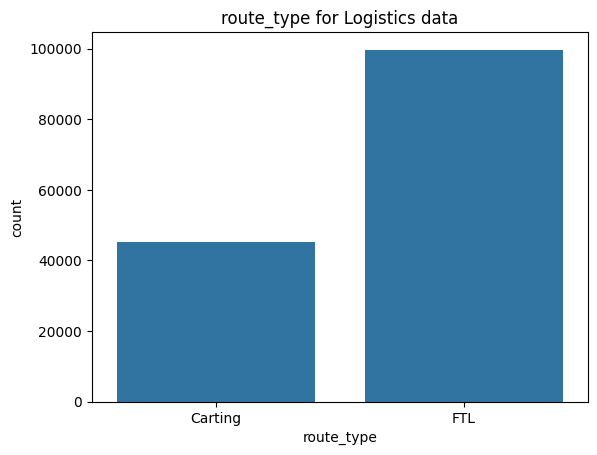

In [13]:
sns.countplot(data=df,x='route_type')
plt.title("route_type for Logistics data")
plt.show()

In [14]:
#check cardinality
df['route_type'].value_counts(normalize=True).round(4)*100

,proportion
route_type,
FTL,68.79
Carting,31.21


- Most frequent route_type = "FTL"  having 69%

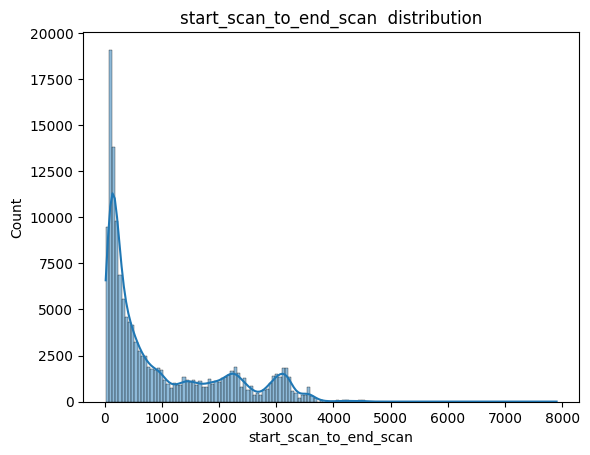

In [15]:
sns.histplot(data=df,x='start_scan_to_end_scan',kde=True)
plt.title("start_scan_to_end_scan  distribution")
plt.show()

- Most values are below 4000 with few outliers
- peak range is between (0,500)

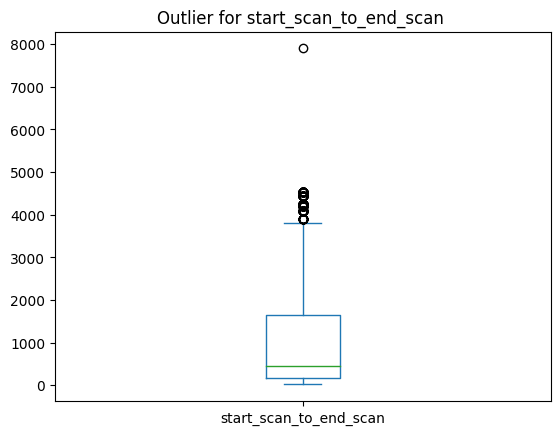

In [16]:
df['start_scan_to_end_scan'].plot(kind="box")
plt.title("Outlier for start_scan_to_end_scan ")
plt.show()

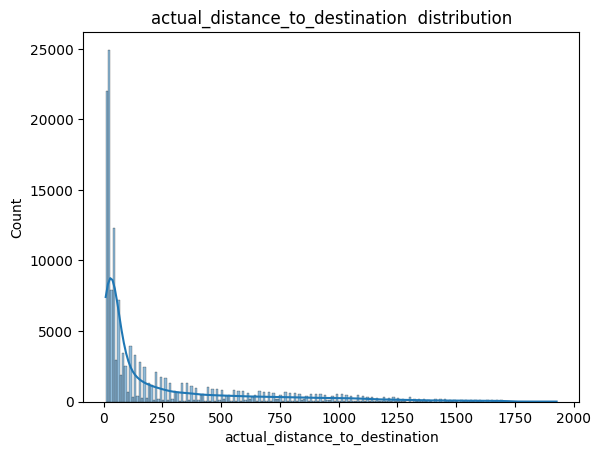

In [17]:
sns.histplot(data=df,x='actual_distance_to_destination',kde=True)
plt.title("actual_distance_to_destination  distribution")
plt.show()

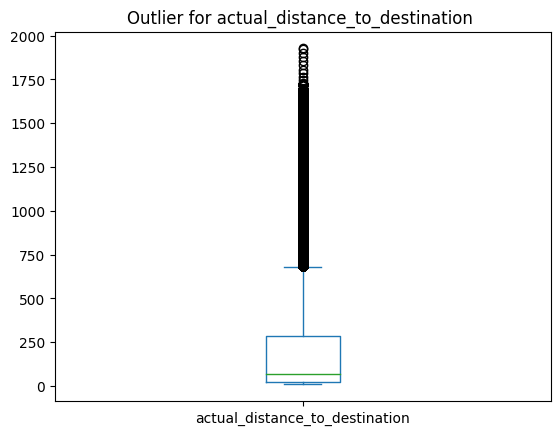

In [18]:
df['actual_distance_to_destination'].plot(kind="box")
plt.title("Outlier for actual_distance_to_destination ")
plt.show()

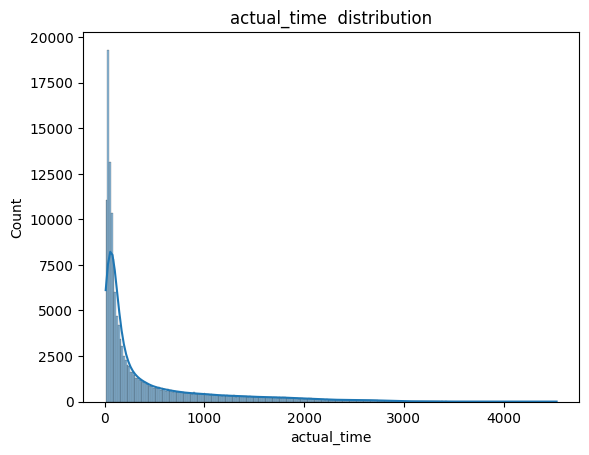

In [19]:
sns.histplot(data=df,x='actual_time',kde=True)
plt.title("actual_time  distribution")
plt.show()

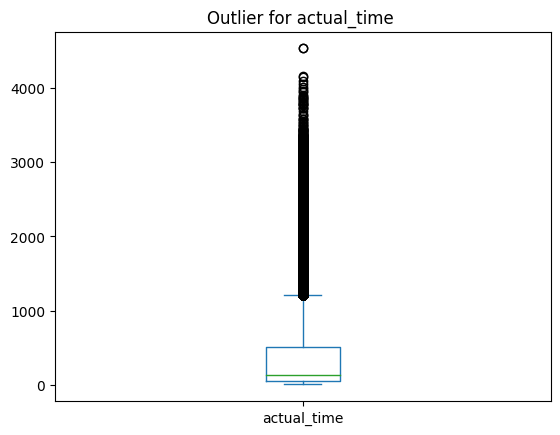

In [20]:
df['actual_time'].plot(kind="box")
plt.title("Outlier for actual_time ")
plt.show()

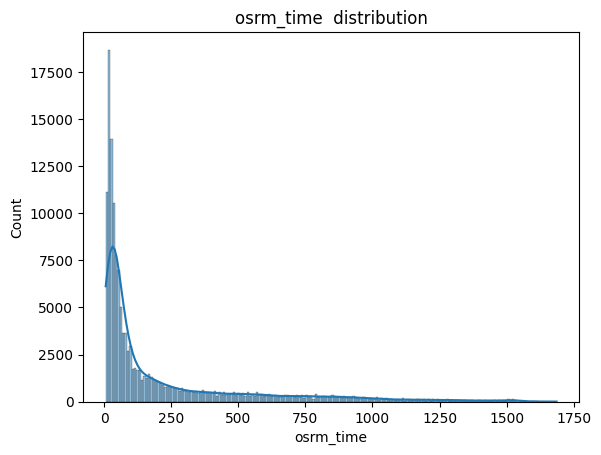

In [21]:
sns.histplot(data=df,x='osrm_time',kde=True)
plt.title("osrm_time  distribution")
plt.show()

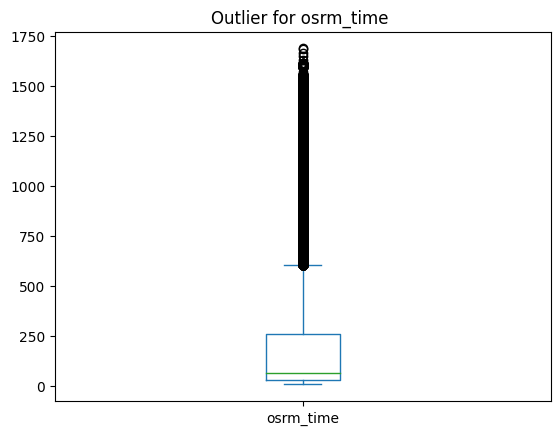

In [22]:
df['osrm_time'].plot(kind="box")
plt.title("Outlier for osrm_time ")
plt.show()

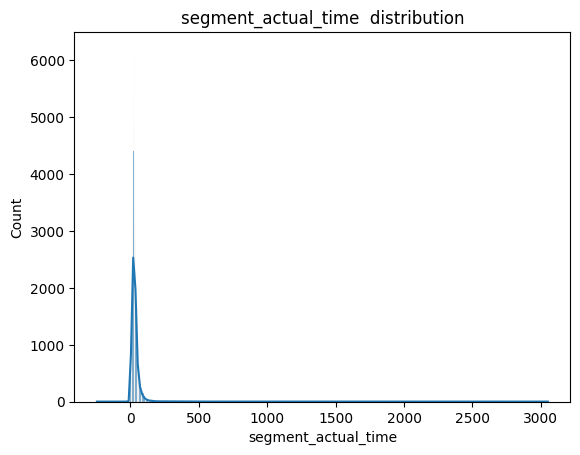

In [23]:
sns.histplot(data=df,x='segment_actual_time',kde=True)
plt.title("segment_actual_time  distribution")
plt.show()

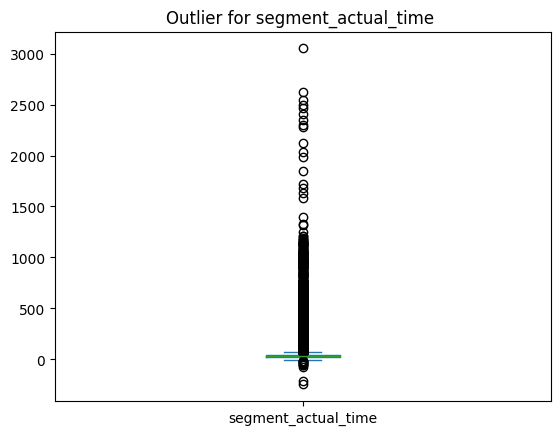

In [24]:
df['segment_actual_time'].plot(kind="box")
plt.title("Outlier for segment_actual_time ")
plt.show()

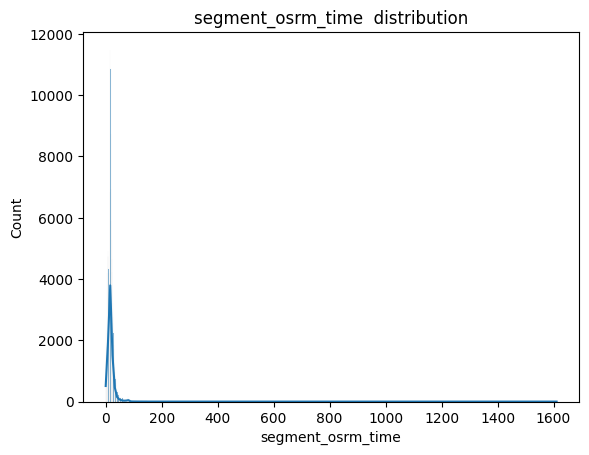

In [25]:
sns.histplot(data=df,x='segment_osrm_time',kde=True)
plt.title("segment_osrm_time  distribution")
plt.show()

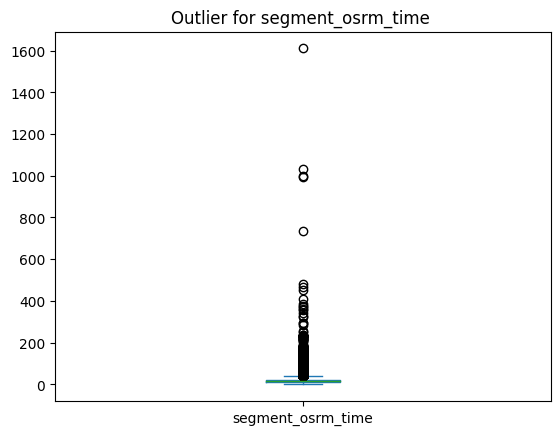

In [26]:
df['segment_osrm_time'].plot(kind="box")
plt.title("Outlier for segment_osrm_time ")
plt.show()

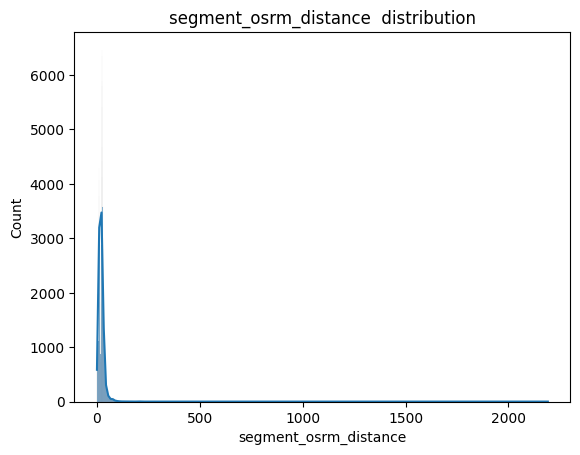

In [27]:
sns.histplot(data=df,x='segment_osrm_distance',kde=True)
plt.title("segment_osrm_distance  distribution")
plt.show()

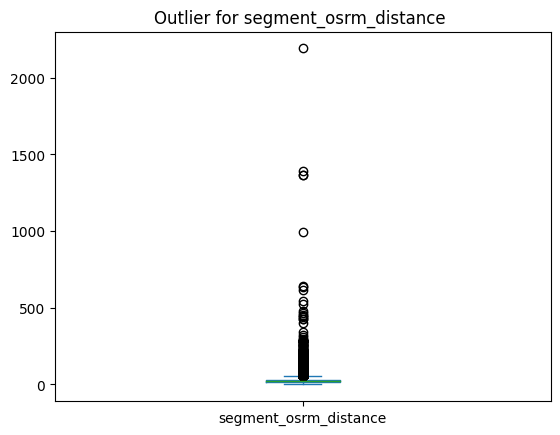

In [28]:
df['segment_osrm_distance'].plot(kind="box")
plt.title("Outlier for segment_osrm_distance ")
plt.show()

- Most of numeric data is skewed and has outlier. Further analysis is required to idenity the nature of outlier data

## 1.7 Correlation Analysis

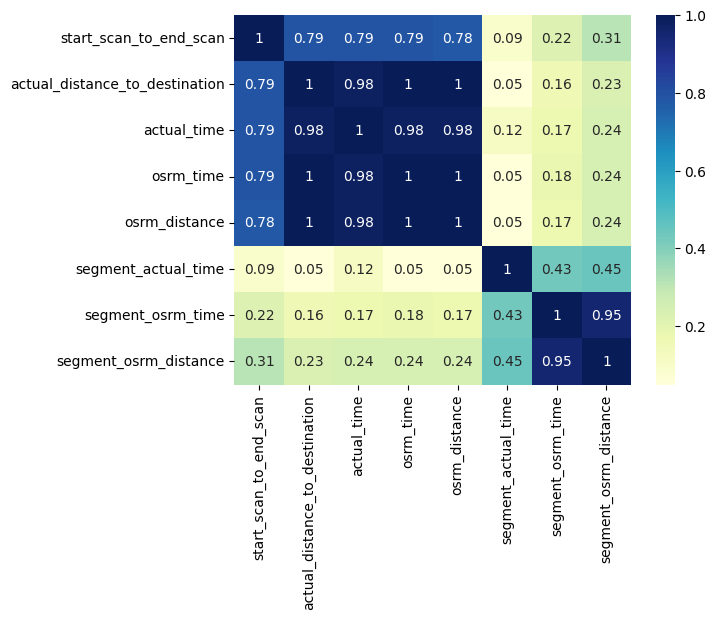

In [29]:
# plotting correlation heatmap
num_df = df.select_dtypes(include=['number'])
dataplot = sns.heatmap(num_df.corr().round(2), cmap="YlGnBu", annot=True)

From the map we see:   
- start_scan_to_end_scan is highly correlated with actual_distance_to_destination, actual_time, osrm_time
- segment_osrm_time,segment_osrm_distance are corelated
- osrm_time,osrm_distance are corelated

# 2.0 Missing values & treatment

In [30]:
null_count=(df.isnull().sum() /df.shape[0] )*100
null_count[ null_count.values >0]

,0
source_name,0.202254
destination_name,0.180165


- columns source_name,destination_name have nulls    
- since the nulls is very small precentage we can drop these records

In [31]:
#drop null records
df.dropna(inplace=True)

#check if nulls are replaced
df.isnull().sum()

,0
trip_creation_time,0
route_type,0
trip_uuid,0
source_center,0
source_name,0
destination_center,0
destination_name,0
od_start_time,0
od_end_time,0
start_scan_to_end_scan,0


## 2.1 Outlier Analysis

In [32]:
def outlier_chk(col):
    #calculate q1,q3
    q1 = np.percentile(df[col] , 25)
    q3 = np.percentile(df[col] , 75)
    iqr = q3-q1

    #calculate high,low limit
    hl = q3+1.5*iqr
    ll = q1-1.5*iqr

    #calculate lower  outier count
    out_l = df[df[col]<ll]
    num_l = len(out_l)

    #calculate higher outier count
    out_h = df[df[col]>hl]
    num_h= len(out_h)

    #calculate  total outier count
    num_tot = num_h+ num_l

    cnt_per=num_tot*100/len(df)

    print(f'column: {col}')
    print(f'count   : {num_tot} percent: {round(cnt_per,2)}')


In [33]:
num_cols = df.select_dtypes(include= np.number).columns

print('==== OUTLIER ANALYSIS =======')
for col in num_cols:
    outlier_chk(col)

==== OUTLIER ANALYSIS =======
column: start_scan_to_end_scan
count   : 373 percent: 0.26
column: actual_distance_to_destination
count   : 17818 percent: 12.35
column: actual_time
count   : 16507 percent: 11.44
column: osrm_time
count   : 17406 percent: 12.06
column: osrm_distance
count   : 17547 percent: 12.16
column: segment_actual_time
count   : 9262 percent: 6.42
column: segment_osrm_time
count   : 6348 percent: 4.4
column: segment_osrm_distance
count   : 4295 percent: 2.98


**Conclusion** : Since removing outlier will cause removal of 12% data, it is better to retain outliers.Also from the graphics the distribution of data is similar for columns so it is better to retain outliers

# 3.0   Aggregation of fields

In [34]:
grp1= df.groupby(['trip_uuid','source_center','destination_center']).agg(
   trip_creation_time = ("trip_creation_time", "first"),
   route_type = ("route_type", "first"),
   source_name = ("source_name", "first"),
   destination_name = ("destination_name", "first"),
   od_start_time = ("od_start_time", "first"),
   od_end_time = ("od_end_time", "first"),
   start_scan_to_end_scan = ("start_scan_to_end_scan", "first"),

   actual_distance_to_destination = ("actual_distance_to_destination", "max"),
   actual_time = ("actual_time", "max"),
   osrm_time = ("osrm_time", "max"),
   osrm_distance = ("osrm_distance", "max"),

   segment_actual_time = ("segment_actual_time", "sum"),
   segment_osrm_time = ("segment_osrm_time", "sum"),
   segment_osrm_distance = ("segment_osrm_distance", "sum"),
    )

In [35]:
grp1.head()

trip_creation_time  \
trip_uuid               source_center destination_center                              
trip-153671041653548748 IND209304AAA  IND000000ACB       2018-09-12 00:00:16.535741   
                        IND462022AAA  IND209304AAA       2018-09-12 00:00:16.535741   
trip-153671042288605164 IND561203AAB  IND562101AAA       2018-09-12 00:00:22.886430   
                        IND572101AAA  IND561203AAB       2018-09-12 00:00:22.886430   
trip-153671043369099517 IND000000ACB  IND160002AAC       2018-09-12 00:00:33.691250   

                                                         route_type  \
trip_uuid               source_center destination_center              
trip-153671041653548748 IND209304AAA  IND000000ACB              FTL   
                        IND462022AAA  IND209304AAA              FTL   
trip-153671042288605164 IND561203AAB  IND562101AAA          Carting   
                        IND572101AAA  IND561203AAB          Carting   
trip-153671043369099517 IND000000ACB  IND160002AAC              FTL   

                                                                                 source_name  \
trip_uuid               source_center destination_center                                       
trip-153671041653548748 IND209304AAA  IND000000ACB        Kanpur_Central_H_6 (Uttar Pradesh)   
                        IND462022AAA  IND209304AAA        Bhopal_Trnsport_H (Madhya Pradesh)   
trip-153671042288605164 IND561203AAB  IND562101AAA         Doddablpur_ChikaDPP_D (Karnataka)   
                        IND572101AAA  IND561203AAB             Tumkur_Veersagr_I (Karnataka)   
trip-153671043369099517 IND000000ACB  IND160002AAC             Gurgaon_Bilaspur_HB (Haryana)   

                                                                            destination_name  \
trip_uuid               source_center destination_center                                       
trip-153671041653548748 IND209304AAA  IND000000ACB             Gurgaon_Bilaspur_HB (Haryana)   
                        IND462022AAA  IND209304AAA        Kanpur_Central_H_6 (Uttar Pradesh)   
trip-153671042288605164 IND561203AAB  IND562101AAA         Chikblapur_ShntiSgr_D (Karnataka)   
                        IND572101AAA  IND561203AAB         Doddablpur_ChikaDPP_D (Karnataka)   
trip-153671043369099517 IND000000ACB  IND160002AAC            Chandigarh_Mehmdpur_H (Punjab)   

                                                                      od_start_time  \
trip_uuid               source_center destination_center                              
trip-153671041653548748 IND209304AAA  IND000000ACB       2018-09-12 16:39:46.858469   
                        IND462022AAA  IND209304AAA       2018-09-12 00:00:16.535741   
trip-153671042288605164 IND561203AAB  IND562101AAA       2018-09-12 02:03:09.655591   
                        IND572101AAA  IND561203AAB       2018-09-12 00:00:22.886430   
trip-153671043369099517 IND000000ACB  IND160002AAC       2018-09-14 03:40:17.106733   

                                                                        od_end_time  \
trip_uuid               source_center destination_center                              
trip-153671041653548748 IND209304AAA  IND000000ACB       2018-09-13 13:40:23.123744   
                        IND462022AAA  IND209304AAA       2018-09-12 16:39:46.858469   
trip-153671042288605164 IND561203AAB  IND562101AAA       2018-09-12 03:01:59.598855   
                        IND572101AAA  IND561203AAB       2018-09-12 02:03:09.655591   
trip-153671043369099517 IND000000ACB  IND160002AAC       2018-09-14 17:34:55.442454   

                                                          start_scan_to_end_scan  \
trip_uuid               source_center destination_center                           
trip-153671041653548748 IND209304AAA  IND000000ACB                        1260.0   
                        IND462022AAA  IND209304AAA                         999.0   
trip-153671042288605164 IND561203AAB  IND562101AAA     

In [36]:
grp1_srt = grp1.sort_values(by=['trip_uuid','od_start_time'])

grp2= grp1_srt.groupby(['trip_uuid']).agg(
   trip_creation_time = ("trip_creation_time", "first"),
   route_type = ("route_type", "first"),
   source_name = ("source_name", "first"),
   destination_name = ("destination_name", "last"),
   od_start_time = ("od_start_time", "min"),
   od_end_time = ("od_end_time", "max"),
   start_scan_to_end_scan = ("start_scan_to_end_scan", "sum"),

   actual_distance_to_destination = ("actual_distance_to_destination", "sum"),
   actual_time = ("actual_time", "sum"),
   osrm_time = ("osrm_time", "sum"),
   osrm_distance = ("osrm_distance", "sum"),

   segment_actual_time = ("segment_actual_time", "sum"),
   segment_osrm_time = ("segment_osrm_time", "sum"),
   segment_osrm_distance = ("segment_osrm_distance", "sum"),

)


In [37]:
grp2.head()

,trip_creation_time,route_type,source_name,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance
trip_uuid,,,,,,,,,,,,,,
trip-153671041653548748,2018-09-12 00:00:16.535741,FTL,Bhopal_Trnsport_H (Madhya Pradesh),Gurgaon_Bilaspur_HB (Haryana),2018-09-12 00:00:16.535741,2018-09-13 13:40:23.123744,2259.0,824.732854,1562.0,743.0,991.3523,1548.0,1008.0,1320.4733
trip-153671042288605164,2018-09-12 00:00:22.886430,Carting,Tumkur_Veersagr_I (Karnataka),Chikblapur_ShntiSgr_D (Karnataka),2018-09-12 00:00:22.886430,2018-09-12 03:01:59.598855,180.0,73.186911,143.0,68.0,85.1110,141.0,65.0,84.1894
trip-153671043369099517,2018-09-12 00:00:33.691250,FTL,Bangalore_Nelmngla_H (Karnataka),Chandigarh_Mehmdpur_H (Punjab),2018-09-12 00:00:33.691250,2018-09-14 17:34:55.442454,3933.0,1932.273969,3347.0,1741.0,2372.0852,3308.0,1941.0,2545.2678
trip-153671046011330457,2018-09-12 00:01:00.113710,Carting,Mumbai Hub (Maharashtra),Mumbai_MiraRd_IP (Maharashtra),2018-09-12 00:01:00.113710,2018-09-12 01:41:29.809822,100.0,17.175274,59.0,15.0,19.6800,59.0,16.0,19.8766
trip-153671052974046625,2018-09-12 00:02:09.740725,FTL,Bellary_Dc (Karnataka),Bellary_Dc (Karnataka),2018-09-12 00:02:09.740725,2018-09-12 12:00:30.683231,717.0,127.448500,341.0,117.0,146.7918,340.0,115.0,146.7919


#  4.0 split data & create features

In [38]:
def split_text(dd,col):
    '''
    split text into city,area,code,state
    '''
    # split text by '(' to create state feature
    txt=dd[col].str.split('(')
    txt_state=txt.str[1]
    txt_state=txt_state.str.replace(')','')
    pref =col.split('_')[0]
    name = pref+'_state'
    dd[name]=txt_state

    # replace '_' by ' '
    txt_city_area_code =txt.str[0].str.replace('_',' ')
    # split txt into words
    txt_city_area_code = txt_city_area_code.str.split()

    # assign 1st word to city column
    name = pref+'_city'
    dd[name] = txt_city_area_code.str[0]

    # assign 2nd word to area column
    name = pref+'_area'
    dd[name] = txt_city_area_code.str[1]

    # assign words after 2 to code column
    name = pref+'_code'
    dd[name] = txt_city_area_code.str[2:]
    #convert list to string, join word with '_'
    dd[name] = dd[name].apply(lambda x: '_'.join(x))

    return dd


In [39]:
col='source_name'
grp1=split_text(grp1,col)

col='destination_name'
grp1=split_text(grp1,col)

In [40]:
grp1['od_time_diff'] =grp1['od_end_time']-grp1['od_start_time']
grp1['od_time_diff'] = grp1['od_time_diff'].astype('timedelta64[ms]')

# create columns for year,month,day
grp1['trip_creation_yr']= grp1['trip_creation_time'].dt.year
grp1['trip_creation_mn'] =grp1['trip_creation_time'].dt.month
grp1['trip_creation_day']= grp1['trip_creation_time'].dt.day

In [41]:
grp1.head(1).T

trip_uuid,trip-153671041653548748
source_center,IND209304AAA
destination_center,IND000000ACB
trip_creation_time,2018-09-12 00:00:16.535741
route_type,FTL
source_name,Kanpur_Central_H_6 (Uttar Pradesh)
destination_name,Gurgaon_Bilaspur_HB (Haryana)
od_start_time,2018-09-12 16:39:46.858469
od_end_time,2018-09-13 13:40:23.123744
start_scan_to_end_scan,1260.0
actual_distance_to_destination,383.759164


 # 5.0 Handling categorical values

In [42]:
#encode column route_type
route_type_encode = pd.get_dummies(grp1['route_type'])

grp1 = pd.concat([grp1,route_type_encode],axis=1)

In [43]:
#dropping the original column
grp1.drop(['route_type'],axis=1, inplace=True)

In [44]:
grp1.head(1).T

trip_uuid,trip-153671041653548748
source_center,IND209304AAA
destination_center,IND000000ACB
trip_creation_time,2018-09-12 00:00:16.535741
source_name,Kanpur_Central_H_6 (Uttar Pradesh)
destination_name,Gurgaon_Bilaspur_HB (Haryana)
od_start_time,2018-09-12 16:39:46.858469
od_end_time,2018-09-13 13:40:23.123744
start_scan_to_end_scan,1260.0
actual_distance_to_destination,383.759164
actual_time,732.0


 Similar procedure can be used to encode other string columns. The drawback being as carinality increases the dimension of one-hot  encoding also increases.

 # 6.0 Column Normalization / Standardization

In [45]:
num_cols = grp1.select_dtypes(include= np.number).columns

# define standard scaler
scaler = StandardScaler()

num_data= grp1[num_cols]

# Convert Timedelta columns to numeric (seconds)
for col in num_data.select_dtypes(include=['timedelta64[ns]']).columns:
    num_data[col] = num_data[col].dt.total_seconds()

# transform data
scale_data = scaler.fit_transform(num_data)

In [46]:
scale_data

array([[ 2.17961526,  1.38616705,  1.37682392, ...,  0.        ,
        -0.37069732, -0.81098806],
       [ 1.58792397,  1.65860099,  1.63089189, ...,  0.        ,
        -0.37069732, -0.81098806],
       [-0.54533849, -0.32380353, -0.39905935, ...,  0.        ,
        -0.37069732, -0.81098806],
       ...,
       [-0.57707672, -0.38085765, -0.44313236, ...,  0.        ,
         2.69761867, -1.9513775 ],
       [-0.02619173, -0.24808079,  0.08315129, ...,  0.        ,
         2.69761867, -1.9513775 ],
       [-0.52720236, -0.31956201, -0.412022  , ...,  0.        ,
         2.69761867, -1.9513775 ]])

# 7.0  Comparison & Visualization of time and distance fields

### 7.1 Comparing od_time_diff(od_end_time- od_start_time)  and start_scan_to_end_scan.

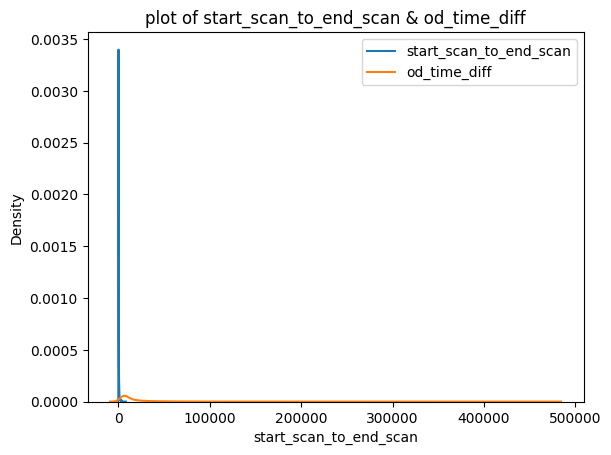

In [47]:
# Convert 'od_time_diff' to numeric (seconds) if it's a Timedelta column
if pd.api.types.is_timedelta64_dtype(grp1['od_time_diff']):
    grp1['od_time_diff'] = grp1['od_time_diff'].dt.total_seconds()

#if 'od_time_diff' is of type object i.e string , convert to timedelta and then to numeric
elif grp1['od_time_diff'].dtype == 'object':
    grp1['od_time_diff'] = pd.to_timedelta(grp1['od_time_diff']).dt.total_seconds()

sns.kdeplot(data=grp1, x='start_scan_to_end_scan',label='start_scan_to_end_scan')
sns.kdeplot(data=grp1,x='od_time_diff',label='od_time_diff')
plt.title('plot of start_scan_to_end_scan & od_time_diff')
plt.legend()
plt.show()

 From the graph, we observed that graphs of two factors overlap. This shows that these two columns are same.

### 7.2 Comparing  Aggregate Actual time & Aggregate OSRM Time

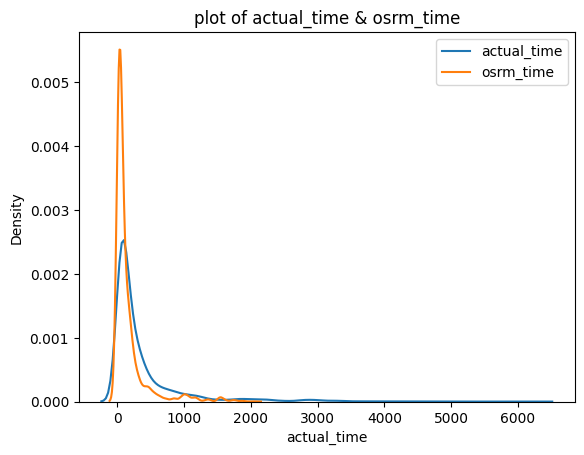

In [48]:
sns.kdeplot(data=grp2, x='actual_time',label='actual_time')
sns.kdeplot(data=grp2,x='osrm_time',label='osrm_time')
plt.title('plot of actual_time & osrm_time')
plt.legend()
plt.show()

The graph shows that graphs are different. This shows that attributes actual_time & osrm_time are different

### 7.3 Comparing  Aggregate Actual time & Aggregate segment_actual_time

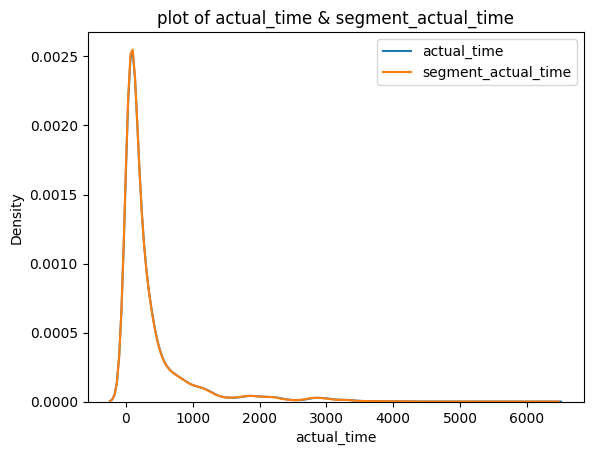

In [49]:
sns.kdeplot(data=grp2, x='actual_time',label='actual_time')
sns.kdeplot(data=grp2,x='segment_actual_time',label='segment_actual_time')
plt.title('plot of actual_time & segment_actual_time')
plt.legend()
plt.show()

 From the graph, we observed that graphs of two factors overlap. This shows that these two columns are same.

### 7.4 Comparing  Aggregate OSRM distance & Aggregate Segment osrm distance

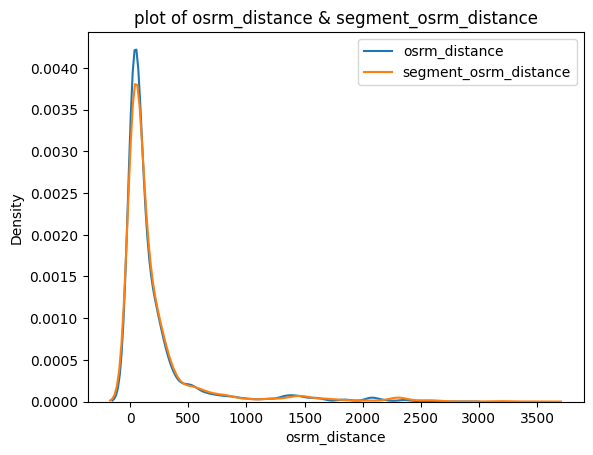

In [50]:
sns.kdeplot(data=grp2, x='osrm_distance',label='osrm_distance')
sns.kdeplot(data=grp2,x='segment_osrm_distance',label='segment_osrm_distance')
plt.title('plot of osrm_distance & segment_osrm_distance')
plt.legend()
plt.show()

 From the graph, we observed that graphs of two factors do not overlap. This shows that these two columns are not same.

### 7.5 Comparing  Aggregate OSRM time & Aggregate Segment osrm time

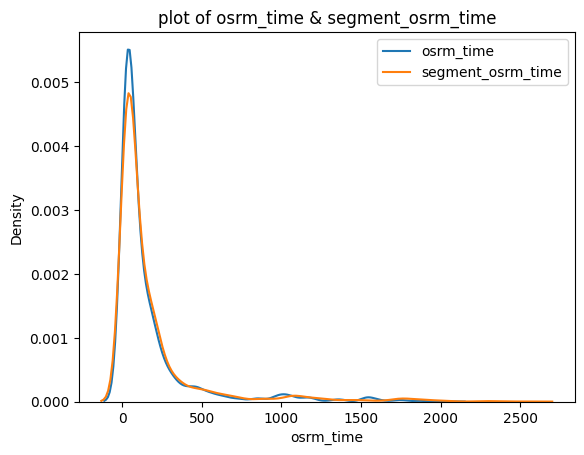

In [51]:
sns.kdeplot(data=grp2, x='osrm_time',label='osrm_time')
sns.kdeplot(data=grp2,x='segment_osrm_time',label='segment_osrm_time')
plt.title('plot of osrm_time & segment_osrm_time')
plt.legend()
plt.show()

 From the graph, we observed that graphs of two factors overlap mostly. This shows that these two columns are same.

# 8.0  Checking relationship between aggregated fields

In [52]:
def check_pval(pval,alpha=0.05):
    '''
    check signifance of p-value
    default alpha=0.05
    '''
    print(f'p-value:{pval} alpha:{alpha}')
    if pval < alpha:
       print("Null Hypothesis rejected")
    else:
       print("Failed to reject Null hypothesis")

### 8.1 Comparing od_time_diff(od_end_time- od_start_time)  and start_scan_to_end_scan.

### proof  using Hypothesis Testing (2 sample T-test)
We perform 2-tailed test so  
**H0 (Null Hypothesis)** : $\mu_1 = \mu_2$ means are same for od_time_diff, start_scan_to_end_scan   
**Ha (Alternate Hypothesis)** : $\mu_1 \neq \mu_2$ means are not same for od_time_diff, start_scan_to_end_scan

In [53]:
sample1 = grp1['start_scan_to_end_scan']
sample2 = grp1['od_time_diff']

#set significance level(alpha)
alpha=0.05/2 # for 2-tailed test

#perform 2 sample t-test
test_stat,p_val = stats.ttest_ind(sample1,sample2) # 2-tailed test

#check significance
check_pval(p_val,alpha)

p-value:0.0 alpha:0.025
Null Hypothesis rejected


**Conclusion** : t-test did not reject null hypothesis,we can say the means are equal with 95% confidence.    
So means are same for start_scan_to_end_scan,od_time_diff

### 8.2 Comparing  Aggregate Actual time & Aggregate OSRM Time

### proof  using Hypothesis Testing (2 sample T-test)
We perform 2-tailed test so  
**H0 (Null Hypothesis)** : $\mu_1 = \mu_2$ means are same for actual_time, osrm_time   
**Ha (Alternate Hypothesis)** : $\mu_1 \neq \mu_2$ means are not same for actual_time, osrm_time

In [54]:
sample1 = grp2['actual_time']
sample2 = grp2['osrm_time']

#set significance level(alpha)
alpha=0.05/2 # for 2-tailed test

#perform 2 sample t-test
test_stat,p_val = stats.ttest_ind(sample1,sample2) # 2-tailed test

#check significance
check_pval(p_val,alpha)

p-value:2.471871372960792e-307 alpha:0.025
Null Hypothesis rejected


**Conclusion** : t-test did  rejects null hypothesis,we can say the means are not equal with 95% confidence.    
So means are not same for actual_time,osrm_time

### 8.3 Comparing  Aggregate Actual time & Aggregate segment_actual_time

### proof  using Hypothesis Testing (2 sample T-test)
We perform 2-tailed test so  
**H0 (Null Hypothesis)** : $\mu_1 = \mu_2$ means are same for actual_time, segment_actual_time   
**Ha (Alternate Hypothesis)** : $\mu_1 \neq \mu_2$ means are not same for actual_time, segment_actual_time

In [55]:
sample1 = grp2['actual_time']
sample2 = grp2['segment_actual_time']

#set significance level(alpha)
alpha=0.05/2 # for 2-tailed test

#perform 2 sample t-test
test_stat,p_val = stats.ttest_ind(sample1,sample2) # 2-tailed test

#check significance
check_pval(p_val,alpha)

p-value:0.6174479719707524 alpha:0.025
Failed to reject Null hypothesis


**Conclusion** : t-test did not reject null hypothesis,we can say the means are equal with 95% confidence.    
So means are same for actual_time,segment_actual_time

### 8.4 Comparing  Aggregate OSRM distance & Aggregate Segment osrm distance

### proof  using Hypothesis Testing (2 sample T-test)
We perform 2-tailed test so  
**H0 (Null Hypothesis)** : $\mu_1 = \mu_2$ means are same for osrm_distance, segment_osrm_distance   
**Ha (Alternate Hypothesis)** : $\mu_1 \neq \mu_2$ means are not same for osrm_distance, segment_osrm_distance

In [56]:
sample1 = grp2['osrm_distance']
sample2 = grp2['segment_osrm_distance']

#set significance level(alpha)
alpha=0.05/2 # for 2-tailed test

#perform 2 sample t-test
test_stat,p_val = stats.ttest_ind(sample1,sample2) # 2-tailed test

#check significance
check_pval(p_val,alpha)

p-value:8.255072509709287e-05 alpha:0.025
Null Hypothesis rejected


**Conclusion** : t-test did reject null hypothesis,we can say the means are not equal with 95% confidence.    
So means are not same for osrm_distance,segment_osrm_distance

### 8.5 Comparing  Aggregate OSRM time & Aggregate Segment osrm time

### proof  using Hypothesis Testing (2 sample T-test)
We perform 2-tailed test so  
**H0 (Null Hypothesis)** : $\mu_1 = \mu_2$ means are same for osrm_time, segment_osrm_time   
**Ha (Alternate Hypothesis)** : $\mu_1 \neq \mu_2$ means are not same for osrm_time, segment_osrm_time

In [57]:
sample1 = grp2['osrm_time']
sample2 = grp2['segment_osrm_time']

#set significance level(alpha)
alpha=0.05/2 # for 2-tailed test

#perform 2 sample t-test
test_stat,p_val = stats.ttest_ind(sample1,sample2) # 2-tailed test

#check significance
check_pval(p_val,alpha)

p-value:3.7220036379152134e-08 alpha:0.025
Null Hypothesis rejected


**Conclusion** : t-test did reject null hypothesis,we can say the means are not equal with 95% confidence.    
So means are not same for osrm_time,segment_osrm_time

# 9.0 Business Insights

## 9.1 Busiest Cities

In [58]:
city_grp=grp1.groupby(['source_city','destination_city']).agg(
    count=('source_city','count'),
    avg_time=('actual_time','mean'),
    avg_dist=('actual_distance_to_destination','mean'),
).sort_values('count',ascending=False).round(2)

city_grp.head(10)

,,count,avg_time,avg_dist
source_city,destination_city,,,
Mumbai,Mumbai,622,56.28,14.01
Bengaluru,Bengaluru,565,79.28,29.10
Bhiwandi,Mumbai,512,76.26,22.36
Bangalore,Bengaluru,492,77.67,27.75
Bengaluru,Bangalore,356,91.26,28.36
Mumbai,Bhiwandi,345,93.55,21.37
Hyderabad,Hyderabad,316,102.39,24.76
Delhi,Gurgaon,248,146.02,40.52
Chennai,Chennai,246,54.89,19.11


From the above we see the 5 busiest citiest are Bengaluru,Mumbai,Bhiwandi,Hyderabad,Delhi

## 9.2 Least Busy Cities

In [59]:
city_grp.tail(10)

count  avg_time  avg_dist
source_city destination_city                           
Hyderabad   Shamshabad            1     122.0     18.20
Rawatsar    Nohar                 1      54.0     36.06
Jagatsghpr  Paradip               1     118.0     49.36
Jagraon     Ludhiana              1     110.0     45.24
Ranikhet    Pithorgarh            1     336.0     74.97
Jaipur      Reengus               1     140.0     70.36
            Renwal                1     122.0     60.12
            Tonk                  1     149.0     68.46
Jaisalmer   Phalodi               1     210.0    146.77
Arani       Vellore               1     153.0     33.48

From the above we get the cities which are least busy

## 9.3 Busiest States

In [60]:
state_grp=grp1.groupby(['source_state','destination_state']).agg(
    count=('source_city','count'),
    avg_time=('actual_time','mean'),
    avg_dist=('actual_distance_to_destination','mean'),
).sort_values('count',ascending=False).round(2)

state_grp[:10]

,,count,avg_time,avg_dist
source_state,destination_state,,,
Maharashtra,Maharashtra,3255,129.48,48.36
Karnataka,Karnataka,3158,92.93,38.10
Tamil Nadu,Tamil Nadu,2021,75.82,34.87
Uttar Pradesh,Uttar Pradesh,1526,136.31,48.45
Telangana,Telangana,1315,97.67,42.10
West Bengal,West Bengal,1296,136.18,37.44
Gujarat,Gujarat,1279,99.16,48.66
Andhra Pradesh,Andhra Pradesh,1139,97.30,46.85
Rajasthan,Rajasthan,1054,139.26,64.22


From the above we see the 5 busiest states are Maharashtra,Karnataka,TamilNadu,Uttar Pradesh,Telangana

## 9.4 Least Busy States

In [61]:
state_grp.tail(10)

,,count,avg_time,avg_dist
source_state,destination_state,,,
Karnataka,Gujarat,1,1687.0,1014.82
Delhi,Assam,1,3306.0,1477.54
Maharashtra,Punjab,1,2172.0,1295.84
Gujarat,Daman & Diu,1,43.0,9.38
Punjab,Maharashtra,1,2891.0,1295.87
West Bengal,Bihar,1,692.0,496.42
Punjab,Karnataka,1,3784.0,1927.45
Jharkhand,Assam,1,2316.0,704.83
Mizoram,Assam,1,190.0,68.01


From the above we get the state routes  which are least busy

**Observations**
- Intracity routes have high count  
- Intrastate routes have high count
- As distance increases count decreases

# 10.0 Recommendations

- FLT routes are popular and should be promoted for further business
- Carting business can be encouraged with discounts
- actual ,osrm times are different. To improve efficiency their difference should be minimised
- Hubs like Bangalore,Mumbai,Delhi,Hyderabead have high activity and can be further promoted
- Intrastate routes also popular and can be promoted for further business
- Most of business is in Maharastra and South India.So more business can be promoted in other states
- Discounts can be offered to long distance routes to improve counts